# Make river_flux csv for fvcom-toolbox
###### author: Ishid @2022/11/16

水質水文データベースの一時間ごとの水位データを一か月ごとにtxt形式でダウンロードしたものをfvcom-toolboxで読み込めるcsvとして出力する。
ダウンロードするときに同一地点では地点名を必ずファイル名に入れること。
中小河川については、teemのinputファイルを参考にして平均流量

In [169]:
import pandas as pd
import numpy as np
from glob import glob
import codecs
from datetime import datetime as dt
from datetime import timedelta
import matplotlib.pyplot as plt
from matplotlib import dates as mdates
import netCDF4

## dat to pd.DataFrame(level)
水位データのcsvを作る

In [229]:


def make_river_level(place_list):
    """
水質水文データベースから各月ごとにdat形式でダウウンロードしたデータを水位の時系列データのDataFrameに変換。
datファイル名に統一した名前を入れ、その名前の一覧をplace_listとする。
    """
    df = pd.DataFrame()
    for place in place_list:
        flux = []
        paths =glob('../'+place+'*') #datがあるpathを指定してください！
    #    print(paths)
        #一日のデータをresの各行で格納
        res = []
        for path in paths:
            with codecs.open(path,'r','utf-8','ignore') as f:
                l = f.readlines()
                for i in range(10,len(l)): #11行目以降が時系列データになっています。
                    res.append(l[i].split(','))
        


        #一日のデータのうち、空白や記号を取り除きます。奇数番目にデータが入っている
        data = [] #1/1 1:00からのデータだが、0:00始まりにしたいので1:00のデータを0:00にも入れる
        for i in range(len(res)):
            data_cld = [res[i][j].replace('    ','') for j in range(1,len(res[i]),2)]
            data.append(data_cld)
        
        #一行のlistにまとめる
        flux = [float(data[0][0])]
        for i in range(len(res)):
            for j in range(24):
                flux.append(float(data[i][j]))
                
       # flux =[float(data[i][j]) for i in range(len(res))for j in range(24)]

        datelist = ["01/01/2020 00:00"]
        for x in range((len(res))*24):
            t = dt.strptime(res[0][0], '%Y/%m/%d')+ timedelta(hours=1) \
                    +timedelta(hours=x)
            t = t.strftime('%m/%d/%Y %H:%M') #書式の変換
            datelist.append(t)
            
        #create df
        df['Time'] = datelist
      #  print(place)
        df[place] = flux
    return df

In [135]:
level = make_river_level(['ishihara','noda','kamenoko','oashi','sugama'])
level = level[level['Time'] != "01/01/2021 00:00"] #toolboxの仕様として、一年分のデータは8784行でなければならない
level

['..\\ishihara202001.dat', '..\\ishihara202002.dat', '..\\ishihara202003.dat', '..\\ishihara202004.dat', '..\\ishihara202005.dat', '..\\ishihara202006.dat', '..\\ishihara202007.dat', '..\\ishihara202008.dat', '..\\ishihara202009.dat', '..\\ishihara202010.dat', '..\\ishihara202011.dat', '..\\ishihara202012.dat']
ishihara
['..\\noda202001.dat', '..\\noda202002.dat', '..\\noda202003.dat', '..\\noda202004.dat', '..\\noda202005.dat', '..\\noda202006.dat', '..\\noda202007.dat', '..\\noda202008.dat', '..\\noda202009.dat', '..\\noda202010.dat', '..\\noda202011.dat', '..\\noda202012.dat']
noda
['..\\kamenoko202001.dat', '..\\kamenoko202002.dat', '..\\kamenoko202003.dat', '..\\kamenoko202004.dat', '..\\kamenoko202005.dat', '..\\kamenoko202006.dat', '..\\kamenoko202007.dat', '..\\kamenoko202008.dat', '..\\kamenoko202009.dat', '..\\kamenoko202010.dat', '..\\kamenoko202011.dat', '..\\kamenoko202012.dat']
kamenoko
['..\\oashi202001.dat', '..\\oashi202002.dat', '..\\oashi202003.dat', '..\\oashi202004

,Time,ishihara,noda,kamenoko,oashi,sugama
0,01/01/2020 00:00,0.57,0.22,0.23,0.39,-0.11
1,01/01/2020 01:00,0.57,0.22,0.23,0.39,-0.11
2,01/01/2020 02:00,0.56,0.22,0.19,0.38,-0.09
3,01/01/2020 03:00,0.56,0.22,0.17,0.38,-0.10
4,01/01/2020 04:00,0.55,0.22,0.17,0.39,-0.09
...,...,...,...,...,...,...
8779,12/31/2020 19:00,0.63,0.08,0.60,0.27,-0.13
8780,12/31/2020 20:00,0.63,0.08,0.43,0.27,-0.14
8781,12/31/2020 21:00,0.64,0.09,0.26,0.27,-0.13
8782,12/31/2020 22:00,0.63,0.10,0.21,0.27,-0.14


## apply H-Q equation 
H-Q式を適用する

In [462]:
def level2flux(df,dev=False):
    """
    水位をH-Q曲線により流量に変換
    https://www.pari.go.jp/search-pdf/no1276.pdf
    チューニング前提。
    #Q隅田川 = 0.6荒川
    #Q 江戸川 = 0.77 × (3.4568 H^3野田 + 5.4914 H^2野田+ 69.395H^野田 +14.053) -10
    #Q 中川 = Q江戸川 Q江戸川 < 250
    #Q 中川 = 0.55*Q江戸川 Q江戸川 ≥ 250
    #Q 鶴見川=1.7 * (18.051*亀^2 -18.055*亀 + 6.8449）+ 20.0
    #大芦橋と菅間の流量の和を荒川から東京湾への流入量とした
    """
    df_new =pd.DataFrame()
    df_Suzuki = pd.DataFrame()
    #Tamagawa = [  -1.30363055  154.86102295 -110.98020149   20.6251756 ]
    #Tsurumigawa = [-1.28642367 13.54415988  4.32584954  2.56546811]
    #Oashi = [  2.39665817  16.50560661  53.54128809 -13.04233257]
    #Sugama_up = [ 9.01724875 38.90381265 41.26862696]
    #Sugama_down = [79.68538694 60.55178271 11.50661536]
   
    columns = df.columns
    
    if 'ishihara' in columns:
        Tamagawa = np.zeros(len(df));Tamagawa_s=np.zeros(len(df))
        for i in range(len(df)):
        ## Suzuki estimate
            flux_ishihara_hq = -21.004*(df['ishihara'][i]**3) +264.5*(df['ishihara'][i]**2) -313.76*df['ishihara'][i]+106.7
            Tamagawa_s[i] = (flux_ishihara_hq-60)/1.76
            
        ## DataBasw estimate
            flux_ishihara_ishi = -1.3*(df['ishihara'][i]**3) +154.9*(df['ishihara'][i]**2) -111.0*df['ishihara'][i]+20.6
            Tamagawa[i] = flux_ishihara_ishi
            if df['ishihara'][i] < 0.62: 
                Tamagawa[i] = 15

        df_new['Tamagawa'] = Tamagawa
        df_Suzuki['Tamagawa'] = Tamagawa_s
        
    if 'oashi' and 'sugama'in columns:
        #Suzuki Estimate
        df_Suzuki['Arakawa'] = 45.677*(df['oashi']**2)-0.2214*df['oashi']-8.03 \
                        +11.696*(df['sugama']**2)+45.795*df['sugama']+10.386 \
                        +48.2
        df_Suzuki['Sumidagawa'] = 0.6*df_Suzuki['Arakawa']
        
        #DB estimate
        #2.39665817  16.50560661  53.54128809 -13.04233257
        df_new['oashi'] = 2.4*(df['oashi']**3) + 16.5 * (df['oashi']**2) + 53.54 * (df['oashi']) -13.0
        
        df_new['sugama'] = df_new['oashi']#dummy
        for i,val in enumerate(df['sugama']):
            if val > 0.5:
                #9.01724875 38.90381265 41.26862696
                df_new['sugama'][i] = 9.02*(val**2) + 38.9 * val + 41.3
            else:
                #79.68538694 60.55178271 11.50661536
                df_new['sugama'][i] = 79.7 * (val**2) + 60.6 * (val) + 11.5
                
        df_new['Akigase'] = df_new['oashi'] + df_new['sugama']
        #df_new['Arakawa'] =48.2 #+ df_new['oashi'] + df_new['sugama'] +
        df_new = df_new.drop(['oashi','sugama'],axis=1)
        
        df_new['Sumidagawa'] = df_new['Akigase']
        for i,val in enumerate(df_new['Akigase']):
            if val < 1000:
                df_new['Sumidagawa'][i] = val*0.3
            else:
                df_new['Sumidagawa'][i] = val*0.17
        
            
    if 'noda' in columns:
        Edogawa = np.zeros(len(df))
        for i,val in enumerate(df['noda']):
            flux_edogawa_hq = 3.4568*(val**3)+5.4914*(val**2)+69.395*val+14.053
            flux_edogawa = 0.77*flux_edogawa_hq -10
            #flux_edogawa = 0.7*flux_edogawa_hq
            if flux_edogawa>0:
                Edogawa[i] = flux_edogawa
            else:
                Edogawa[i] = flux_edogawa
        df_new['Edogawa'] = Edogawa
        for i in range(len(df)):
            if df_new.at[i,'Edogawa'] <250:
                df_new.at[i,'nakagawa'] = df_new.at[i,'Edogawa']
            else:
                df_new.at[i,'nakagawa'] = 0.55 * df_new.at[i,'Edogawa']
                
    if 'kamenoko' in columns:
        Tsurumigawa = np.zeros(len(df))
        for i,val in enumerate(df['kamenoko']):
        #    flux_Tsurumigawa_hq = 18.051*(val**2)-18.055*val+6.8849
        #   flux_Tsurumigawa = 1.7*flux_Tsurumigawa_hq+20
        #   Tsurumigawa[i] = flux_Tsurumigawa #
            flux_Tsurumigawa_hq = -1.29*(val**3) + 13.54*(val**2)-4.33*val+2.57
            Tsurumigawa[i] =1.6 *  flux_Tsurumigawa_hq  +10 
        df_new['Tsurumigawa'] = Tsurumigawa
 
    backup_arakawa = df_new['Akigase']
    
    df_new['nakagawa'] += 48.2
    



    if dev:
        ## devide arakawa
        df_new['EastArakawa'] = df_new['Akigase']/4
        df_new['CenterArakawa'] = df_new['Akigase']/4
        df_new['WestArakawa'] = df_new['Akigase']/4
        df_new['SouthArakawa'] = df_new['Akigase']/4
        df_new = df_new.drop('Akigase',axis=1)

        #also devide Sumidagawa 
        df_new['FirstSumidagawa'] = df_new['Sumidagawa']/3
        df_new['SecondSumidagawa'] = df_new['Sumidagawa']/3
        df_new['ThirdSumidagawa'] = df_new['Sumidagawa']/3
        df_new = df_new.drop('Sumidagawa',axis=1)

        #devide Edogawa
        df_new['OneEdogawa'] = df_new['Edogawa']/3
        df_new['TwoEdogawa'] = df_new['Edogawa']/3
        df_new['ThreeEdogawa'] = df_new['Edogawa']/3
        df_new = df_new.drop('Edogawa',axis=1)

        #devide Tamagawa
        df_new['IchiTamagawa'] = df_new['Tamagawa']/3
        df_new['NiTamagawa'] = df_new['Tamagawa']/3
        df_new['SanTamagawa'] = df_new['Tamagawa']/3
        df_new = df_new.drop('Tamagawa',axis=1)
        
        #devide Nakagawa
        df_new['UnoNakagawa'] = df_new['nakagawa']/3
        df_new['DosNakagawa'] = df_new['nakagawa']/3
        df_new['TresNakagawa'] = df_new['nakagawa']/3
        df_new = df_new.drop('nakagawa',axis=1)
        
    df_new.index = df['Time']
    return df_new,backup_arakawa,df_Suzuki  
flux,backup_arakawa,df_Suzuki  = level2flux(level,dev=True)

#flux.to_csv('river_flux2020.csv')
flux

,Tsurumigawa,EastArakawa,CenterArakawa,WestArakawa,SouthArakawa,FirstSumidagawa,SecondSumidagawa,ThirdSumidagawa,OneEdogawa,TwoEdogawa,ThreeEdogawa,IchiTamagawa,NiTamagawa,SanTamagawa,UnoNakagawa,DosNakagawa,TresNakagawa
Time,,,,,,,,,,,,,,,,,
01/01/2020 00:00,13.639473,4.082746,4.082746,4.082746,4.082746,1.633099,1.633099,1.633099,4.269773,4.269773,4.269773,5.000000,5.000000,5.000000,20.336440,20.336440,20.336440
01/01/2020 01:00,13.639473,4.082746,4.082746,4.082746,4.082746,1.633099,1.633099,1.633099,4.269773,4.269773,4.269773,5.000000,5.000000,5.000000,20.336440,20.336440,20.336440
01/01/2020 02:00,13.563593,4.137766,4.137766,4.137766,4.137766,1.655106,1.655106,1.655106,4.269773,4.269773,4.269773,5.000000,5.000000,5.000000,20.336440,20.336440,20.336440
01/01/2020 03:00,13.550189,4.024123,4.024123,4.024123,4.024123,1.609649,1.609649,1.609649,4.269773,4.269773,4.269773,5.000000,5.000000,5.000000,20.336440,20.336440,20.336440
01/01/2020 04:00,13.550189,4.306046,4.306046,4.306046,4.306046,1.722419,1.722419,1.722419,4.269773,4.269773,4.269773,5.000000,5.000000,5.000000,20.336440,20.336440,20.336440
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12/31/2020 19:00,17.308416,1.918705,1.918705,1.918705,1.918705,0.767482,0.767482,0.767482,1.707989,1.707989,1.707989,3.941583,3.941583,3.941583,17.774655,17.774655,17.774655
12/31/2020 20:00,14.974531,1.821002,1.821002,1.821002,1.821002,0.728401,0.728401,0.728401,1.707989,1.707989,1.707989,3.941583,3.941583,3.941583,17.774655,17.774655,17.774655
12/31/2020 21:00,13.738930,1.918705,1.918705,1.918705,1.918705,0.767482,0.767482,0.767482,1.888691,1.888691,1.888691,4.222084,4.222084,4.222084,17.955358,17.955358,17.955358


## convert to TEEM flux
teemの平均流量の比と等しくなるように、中小河川の比率を変化させる

7.9 Tsurumi V
10.0 Sumida V
36.5 Tama V
75.4 Ara V
108.0 Edo V
3.0 Mama V
5.0 Ebi V
11.1 Yoro V
14.3 Obitsu V
6.3 Koito V
4.1 Murata V
2.0 Hanami V

In [463]:
#https://github.com/estuarine-utokyo/TEEM/blob/main/input/tb2000m23river.dat
all_flux = {}
#75.4 Ara V
#108.0 Edo V
#7.9 Tsurumi V
#10.0 Sumida V
for column in flux.columns:
    all_flux[column] = sum(flux[column])
Q_s = {"Mamagawa":3.0,"Ebigawa":5.0,"Yorogawa":11.1,"Obitsugawa":14.3,"koitogawa":6.3,"Muratagawa":4.1,"Hanamigawa":2.0}
for key in Q_s.keys():
    flux[key] = (flux['OneEdogawa']+flux['TwoEdogawa']+flux['SanTamagawa']) * Q_s[key]/108.0
    #flux[key] = (flux['Edogawa']) * Q_s[key]/108.0
#Q_s2 = {"Arakawa":75.4,"Edogawa":108.0,"Tsurumigawa":7.9,"Sumidagawa":10.0} 
#Q_tama = sum(flux['Tamagawa'])
#for river in Q_s2.keys():
#    Q_year = sum(flux[river])
#    Q_year_true = Q_tama*Q_s2[river]/36.5
#    flux[river] = flux[river] * Q_year_true/Q_year
    
"""
for column in flux.columns:
    for i in range(24*180,24*240):
        print(flux[column][i])
        flux[column][i] = 1.5*flux[column][i]
        print(flux[column][i])
"""
print(flux)

                  Tsurumigawa  EastArakawa  CenterArakawa  WestArakawa  \
Time                                                                     
01/01/2020 00:00    13.639473     4.082746       4.082746     4.082746   
01/01/2020 01:00    13.639473     4.082746       4.082746     4.082746   
01/01/2020 02:00    13.563593     4.137766       4.137766     4.137766   
01/01/2020 03:00    13.550189     4.024123       4.024123     4.024123   
01/01/2020 04:00    13.550189     4.306046       4.306046     4.306046   
...                       ...          ...            ...          ...   
12/31/2020 19:00    17.308416     1.918705       1.918705     1.918705   
12/31/2020 20:00    14.974531     1.821002       1.821002     1.821002   
12/31/2020 21:00    13.738930     1.918705       1.918705     1.918705   
12/31/2020 22:00    13.593388     1.821002       1.821002     1.821002   
12/31/2020 23:00    13.593388     1.821002       1.821002     1.821002   

                  SouthArakawa  First

In [464]:
#columnを確認せよ
print(flux.columns)
#flux = flux.drop([''],axis=1)

Index(['Tsurumigawa', 'EastArakawa', 'CenterArakawa', 'WestArakawa',
       'SouthArakawa', 'FirstSumidagawa', 'SecondSumidagawa',
       'ThirdSumidagawa', 'OneEdogawa', 'TwoEdogawa', 'ThreeEdogawa',
       'IchiTamagawa', 'NiTamagawa', 'SanTamagawa', 'UnoNakagawa',
       'DosNakagawa', 'TresNakagawa', 'Mamagawa', 'Ebigawa', 'Yorogawa',
       'Obitsugawa', 'koitogawa', 'Muratagawa', 'Hanamigawa'],
      dtype='object')


### csvへ出力 

In [466]:

flux.to_csv('river_flux2020DB.csv')
flux.to_csv('river_temp2020DB.csv')
flux.to_csv('river_salt2020DB.csv')
flux.to_csv('river_loc2020DB.csv')
#2023/01/06 divall:荒川、隅田川、江戸川、多摩川の流量を分割した

## 豊水/平水流量を求める 

In [447]:
#平水流量
for river in flux.columns:
    #一日ごとの平均値を出し、それをソートすることで平水流量などを求める
  
    day_river = sorted([np.average(flux[river][i*24:i*24+23]) for i in range(int(np.round(len(flux)/24)))],reverse=True)

    #print("%s: \n kassui=%1.1f, heisui=%1.1f, teisui=%1.1f, hosui=%1.1f" \
    #      %(river,day_river[95-1],day_river[185],day_river[275],day_river[355]))
    
    ave = np.average(flux[river])
    
    print("%s heisui=%1.1f, hosui=%1.1f average=%1.1f" \
          %(river,day_river[185],day_river[95],ave))
#28.40 14.35 9.15 6.17 42.42    
#観測所名 最大流量 豊水流量 平水流量 低水流量 渇水流量 最低流量
#秋ヶ瀬取水堰 2,225 81.37 57.20 47.40 37.69 20.53
#Tama,Ara,Sumida.Edo.Tsurumi    
valid_range_heisui_low = [20,50,30,10,10]
valid_range_heisui_high = [35,80,50,40,13]
valid_range_hosui_low  = [30,70,40,30,16]
valid_range_hosui_high = [60,100,55,100,20]

Tamagawa heisui=20.8, hosui=45.7 average=36.9
Akigase heisui=25.0, hosui=61.8 average=57.0
Arakawa heisui=48.2, hosui=48.2 average=48.2
Sumidagawa heisui=7.5, hosui=18.5 average=17.0
Edogawa heisui=15.4, hosui=52.3 average=37.0
nakagawa heisui=15.4, hosui=52.3 average=36.1
Tsurumigawa heisui=15.5, hosui=16.7 average=17.3


In [146]:
res = 0
for val in flux['Tamagawa']:
    if val > 89.2:
        res +=1
print(res)

258


## 流量のプロット、月平均流量のプロット 

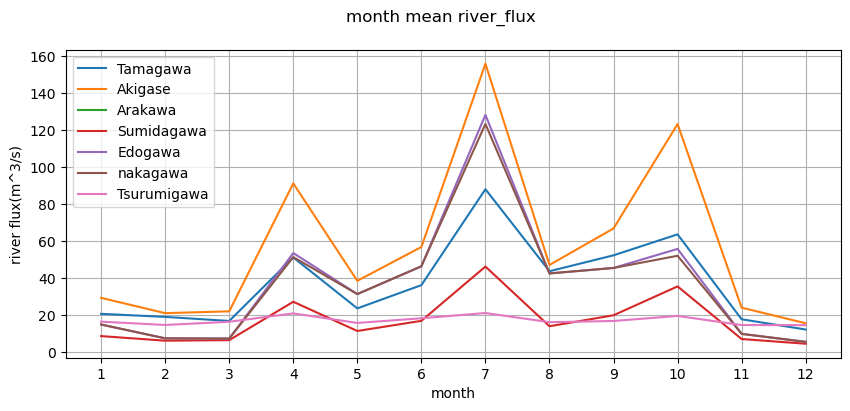

In [446]:
import matplotlib.pyplot as plt
month_river = []
for river in flux.columns:
    if river == 'Arakawa':
        month_river.append([])
    else:
        month_eachriver=[]
        fl = flux[river]
        for i in range(12):
            st = 24*30*i
            month = sum(fl[st:st+24*30])/(24*30)
            month_eachriver.append(month)
        month_river.append(month_eachriver)
#print(month_river)
fig = plt.figure(figsize=(10,4))
ax = fig.add_subplot(1,1,1,xlabel='month',ylabel='river flux(m^3/s)')
for i,river in enumerate(flux.columns):
    ax.plot(month_river[i],label=river)
    i+=1
fig.suptitle('month mean river_flux')
plt.plot();ax.legend();plt.xticks([i for i in range(12)], [i for i in range(1,13)]);ax.grid()
plt.show()

## 水質水文データベースの流量をもとにしたHQ式の作成

In [401]:
def estimate_hq(path,place,up=False,down=False,lev=0,poly=3,plot=True):
    df = make_river_level([path])

    df = df.rename(columns={path: 'flux'})
    df = df[df['Time'] != "01/01/2021 00:00"]
    df = df[df['flux'] !=-9999]
    df_level = make_river_level([place])
    df['level'] = df_level[place]
    if up:
        df = df[df['level'] >= lev]
    if down:
        df = df[df['level'] <= lev]


    x,y = df['level'],df['flux']
    p = np.polyfit(x,y,poly)
    
    #plot
    if plot:
        fig,ax = plt.subplots(figsize=(5,8))
        ax.scatter(x,y,marker='o',color='red',s=1)
        print(len(x))
        l = np.linspace(min(x),max(x),100)
        f = [p[0]*(ll**3) + p[1]*(ll**2) + p[2] * (ll**1) + p[3] for ll in l]
        ax.plot(l,f,alpha=0.5,color='black')

        plt.show()

        fig,ax = plt.subplots()
        estimate = [p[0]*(ll**3) + p[1]*(ll**2) + p[2] * (ll**1) + p[3] for ll in x]
        diff = y -estimate 
        ax.plot(diff)
        #ax.set_ylim(0,0.1)

        fig,ax = plt.subplots()
        ax.scatter(x,y,marker='*',color='red')
        ax.plot(l,f)
        ax.set_ylim(0,100);ax.set_xlim(0,1)
        plt.show()
   # print(p)
    
    return p


In [412]:
Tama = estimate_hq('flux/ishihara','ishihara',plot=False)
print(f"Tamagawa = {Tama}")
Tsurumi = estimate_hq('flux/kamenoko','kamenoko',plot=False)
print(f"Tsurumigawa = {Tsurumi}")
Oashi = estimate_hq('flux/oashi','oashi',plot=False)
print(f"Oashi = {Oashi}")
sugama_up = estimate_hq('flux/sugama','sugama',up=True,lev=0.5,poly=2,plot=False)
print(f"Sugama_up = {sugama_up}")
sugama_down = estimate_hq('flux/sugama','sugama',down=True,lev=0.5,poly=2,plot=False)
print(f"Sugama_down = {sugama_down}")

Tamagawa = [  -1.30363055  154.86102295 -110.98020149   20.6251756 ]
Tsurumigawa = [-1.28642367 13.54415988  4.32584954  2.56546811]
Oashi = [  2.39665817  16.50560661  53.54128809 -13.04233257]
Sugama_up = [ 9.01724875 38.90381265 41.26862696]
Sugama_down = [79.68538694 60.55178271 11.50661536]


In [204]:
#calc RMSE

f = pd.Series(estimate)
corr = y.corr(f)
rmse = np.sum([(yy-ff)**2 for yy,ff in zip(y,f)])/len(y)
print(corr,rmse)

8460 8460
0.5866476597771529 0.2008935505047255


## confirm netCDF input file 

In [35]:

nc = netCDF4.Dataset('C:/Users/ishid/fvcominputs/input/TokyoBay_river.nc','r')
nc.variables.keys()

dict_keys(['river_names', 'time', 'Itime', 'Itime2', 'Times', 'river_flux', 'river_temp', 'river_salt'])

In [36]:
river = nc.variables['river_flux'][:][0].data
river

array([ 9.903056  , 26.521294  ,  3.7485394 , 32.83178   ,  4.0080495 ,
        0.8139498 ,  1.356583  ,  3.0116143 ,  3.8798275 ,  1.7092947 ,
        1.1123981 ,  0.54263324], dtype=float32)

In [37]:
time = nc.variables['time'][:].data
time

array([58849.   , 58849.043, 58849.082, ..., 59214.875, 59214.918,
       59214.957], dtype=float32)

## 公共用水域との比較 

In [295]:
def read_kokyo(path,encoding='shift-jis'):
    df_kokyo = pd.read_csv(path,encoding=encoding,
                           usecols = ['河川名','地点名','採取年月日','採取時刻','流量'])
    df_kokyo = df_kokyo.dropna(subset=['流量'])
    df_kokyo = df_kokyo.reset_index(drop=True)
    df_kokyo['date'] = [dt.strptime(str(df_kokyo['採取年月日'][i]+df_kokyo['採取時刻'][i][0:2]),'%Y/%m/%d%H') 
                        for i in range(len(df_kokyo))] 
    print(df_kokyo.head())
    return df_kokyo
df_kokyo = read_kokyo('../../kokyo/csv/kokyo2020_Tokyo.csv')

   河川名   地点名       採取年月日   採取時刻     流量                date
0  江戸川  新葛飾橋  2020/04/08  08:20  95.53 2020-04-08 08:00:00
1  江戸川  新葛飾橋  2020/04/08  11:20  33.96 2020-04-08 11:00:00
2  江戸川  新葛飾橋  2020/05/13  08:00  61.76 2020-05-13 08:00:00
3  江戸川  新葛飾橋  2020/05/13  11:00  58.34 2020-05-13 11:00:00
4  江戸川  新葛飾橋  2020/06/03  17:05  72.89 2020-06-03 17:00:00


In [ ]:
place = list(set(df_kokyo['地点名']))
river = list(set(df_kokyo['河川名']))
print(place,river)
Tama = df_kokyo[df_kokyo['河川名'] ==  '多摩川']
Tama_d = df_kokyo[df_kokyo['地点名'] ==  '田園調布堰上（調布取水堰）']
#Edo = df_kokyo[df_kokyo['地点名'] ==  '新葛飾橋']

Tama_k = df_kokyo[df_kokyo['地点名'] ==  '第三京浜多摩川橋']
print(list(set(Tama['地点名'])))

In [355]:
def read_Saitama(path):
    df_kokyo_s = pd.read_csv(path,encoding='utf-8',
                            usecols = ['水域名', '地点名','西暦年', '月日', '時分','流量'])
    df_aki = df_kokyo_s[df_kokyo_s['地点名'] =='2秋ケ瀬取水堰' ]
    df_aki = df_aki.reset_index(drop = True)
    df_aki['date'] = [dt.strptime(
                                        str(df_aki['西暦年'][i])
                                      +str(df_aki['月日'][i]//100)
                                      +str(df_aki['月日'][i]%100)
                                      +str(df_aki['時分'][i]//100)
                                      +str(df_aki['時分'][i]%100)
                                                                        ,'%Y.0%m.0%d.0%H.0%S.0') 
                            for i in range(len(df_aki))] 
    return df_aki
df_aki_2019 = read_Saitama('../kokyo_Saitama_2019.csv')
df_aki_2020 = read_Saitama('../kokyo_Saitama_2020.csv')
df_aki = pd.merge(df_aki_2019, df_aki_2020, how='outer')#, on='a'
mask = []
for d in df_aki['date']:
    if d.year  ==  2020:
        mask.append(True)
    else:
        mask.append(False)
df_aki =df_aki[mask]
print(df_aki.head())

     水域名      地点名     西暦年      月日      時分      流量                date
9   荒川中流  2秋ケ瀬取水堰  2020.0   115.0  1305.0   32.10 2020-01-15 13:00:05
10  荒川中流  2秋ケ瀬取水堰  2020.0   205.0  1312.0   47.70 2020-02-05 13:00:12
11  荒川中流  2秋ケ瀬取水堰  2020.0   304.0  1325.0   33.00 2020-03-04 13:00:25
15  荒川中流  2秋ケ瀬取水堰  2020.0  1111.0  1345.0   41.72 2020-11-11 13:00:45
16  荒川中流  2秋ケ瀬取水堰  2020.0   408.0  1220.0  172.65 2020-04-08 12:00:20


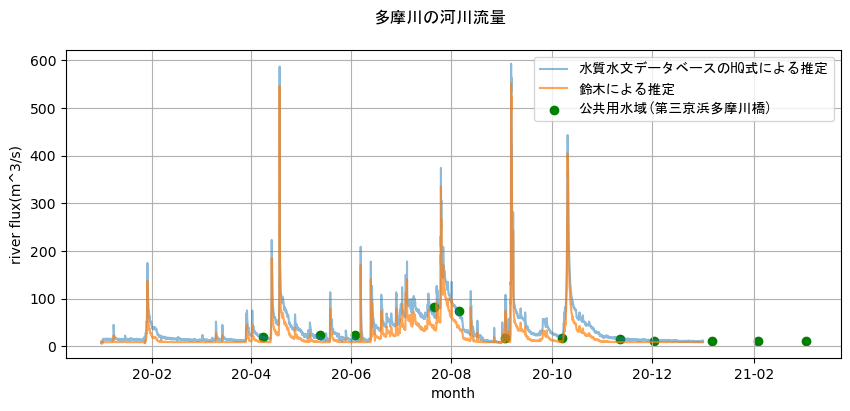

In [360]:
#plot
fig = plt.figure(figsize=(10,4))
ax = fig.add_subplot(1,1,1,xlabel='month',ylabel='river flux(m^3/s)')

date = [dt.strptime(val,"%m/%d/%Y %H:%S") for val in flux.index]

ax.plot(date,flux['Tamagawa'][:],label='水質水文データベースのHQ式による推定',alpha=0.5)
flux_Suzuki_Tama = [-21.004*(val**3) +264.5*(val**2) -313.76*val+106.7 for val in level['ishihara']]
ax.plot(date,flux_Suzuki_Tama,label='鈴木による推定',alpha=0.7)
#ax.scatter(Tama_d['date'],Tama_d['流量'],color='red',label='公共用水域(田園調布堰)')
ax.scatter(Tama_k['date'],Tama_k['流量'],color='green',label='公共用水域(第三京浜多摩川橋)')

plt.suptitle('多摩川の河川流量',fontname="MS Gothic")
ax.xaxis.set_major_locator(mdates.MonthLocator(interval=2))
ax.xaxis.set_major_formatter(mdates.DateFormatter("%y-%m"))
#plt.ylim(0,300)

plt.plot();ax.legend(prop={"family":"MS Gothic"});ax.grid();plt.show()
fig.savefig('../png/compare_Tamagawa.png')

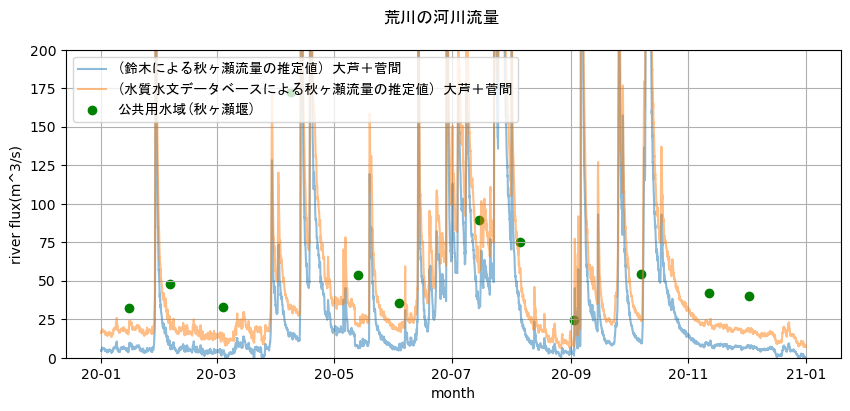

In [452]:
#plot
fig = plt.figure(figsize=(10,4))
ax = fig.add_subplot(1,1,1,xlabel='month',ylabel='river flux(m^3/s)')

date = [dt.strptime(val,"%m/%d/%Y %H:%S") for val in flux.index]

ax.plot(date,df_Suzuki['Arakawa']-48.2,label='(鈴木による秋ヶ瀬流量の推定値) 大芦＋菅間',alpha=0.5)
ax.plot(date,flux['Akigase'],label='(水質水文データベースによる秋ヶ瀬流量の推定値) 大芦＋菅間',alpha=0.5)
#ax.scatter(Tama_d['date'],Tama_d['流量'],color='red',label='公共用水域(田園調布堰)')
ax.scatter(df_aki['date'],df_aki['流量'],color='green',label='公共用水域(秋ヶ瀬堰)')

plt.suptitle('荒川の河川流量',fontname="MS Gothic")
ax.xaxis.set_major_locator(mdates.MonthLocator(interval=2))
ax.xaxis.set_major_formatter(mdates.DateFormatter("%y-%m"))
plt.ylim(0,200)

plt.plot();ax.legend(prop={"family":"MS Gothic"});ax.grid();plt.show()
fig.savefig('../png/compare_Arakawa}.png')